<ipython-input-1-bfdab471b80a>:21: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


100%|██████████| 21.2k/21.2k [00:00<00:00, 30.7MB/s]

First 5 records:    Transaction ID        Date Product Category             Product Name  \
0           10001  2024-01-01      Electronics            iPhone 14 Pro   
1           10002  2024-01-02  Home Appliances         Dyson V11 Vacuum   
2           10003  2024-01-03         Clothing         Levi's 501 Jeans   
3           10004  2024-01-04            Books        The Da Vinci Code   
4           10005  2024-01-05  Beauty Products  Neutrogena Skincare Set   

   Units Sold  Unit Price  Total Revenue         Region Payment Method  
0           2      999.99        1999.98  North America    Credit Card  
1           1      499.99         499.99         Europe         PayPal  
2           3       69.99         209.97           Asia     Debit Card  
3           4       15.99          63.96  North America    Credit Card  
4           1       89.99          89.99         Europe         PayPal  
Shape of data before removing outliers: (240, 9)
Shape of data after removing outliers: (232, 

Random Forest - Mean Squared Error: 4329.049376411157
Random Forest - R-squared: 0.9501079846194842
XGBoost - Mean Squared Error: 4292.613619876421
XGBoost - R-squared: 0.9505279043679946


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Neural Network - Mean Squared Error: 13081.680757606991
Neural Network - R-squared: 0.849234471401987


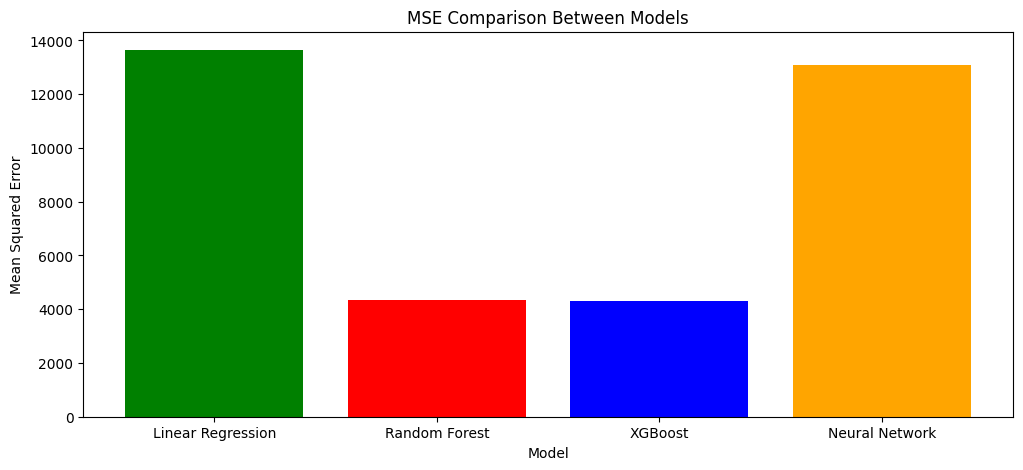

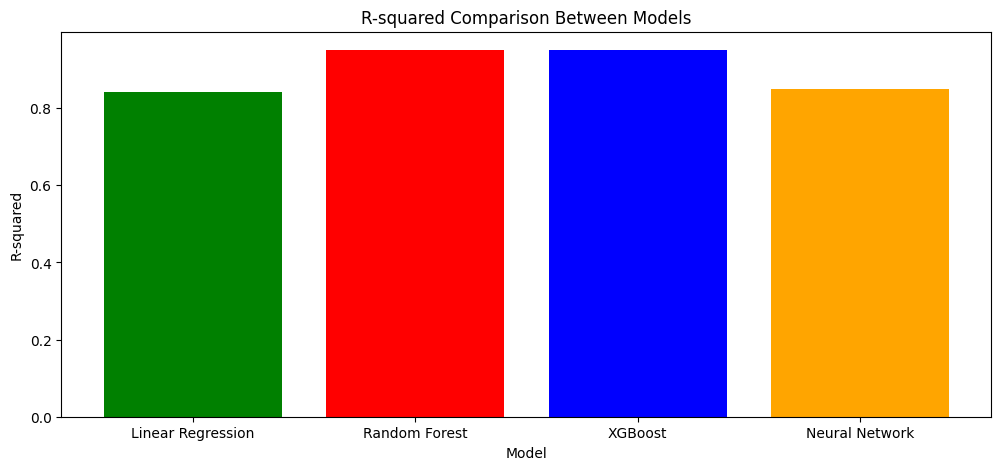

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Online Sales Data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shreyanshverma27/online-sales-dataset-popular-marketplace-data",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())
# Load dataset (assuming df is already loaded)
print("Shape of data before removing outliers:", df.shape)

# Identify and remove outliers using z-score method
z_scores = np.abs((df[['Units Sold', 'Unit Price', 'Total Revenue']] - df[['Units Sold', 'Unit Price', 'Total Revenue']].mean()) / df[['Units Sold', 'Unit Price', 'Total Revenue']].std())
df = df[(z_scores < 3).all(axis=1)]
print("Shape of data after removing outliers:", df.shape)

# Feature Engineering
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

encoder = LabelEncoder()
df['Region_Encoded'] = encoder.fit_transform(df['Region'])
df['Product Category_Encoded'] = encoder.fit_transform(df['Product Category'])
df['Payment Method_Encoded'] = encoder.fit_transform(df['Payment Method'])

X = df[['Units Sold', 'Unit Price', 'Month', 'Day', 'Weekday', 'Region_Encoded', 'Product Category_Encoded', 'Payment Method_Encoded']]
y = df['Total Revenue']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression - Mean Squared Error:", mse_lr)
print("Linear Regression - R-squared:", r2_lr)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - Mean Squared Error:", mse_rf)
print("Random Forest - R-squared:", r2_rf)

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost - Mean Squared Error:", mse_xgb)
print("XGBoost - R-squared:", r2_xgb)

# Neural Network Model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, verbose=0, validation_data=(X_test_scaled, y_test))

y_pred_nn = nn_model.predict(X_test_scaled).flatten()

mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print("Neural Network - Mean Squared Error:", mse_nn)
print("Neural Network - R-squared:", r2_nn)

# Visualization
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network']
mse_values = [mse_lr, mse_rf, mse_xgb, mse_nn]
r2_values = [r2_lr, r2_rf, r2_xgb, r2_nn]

plt.figure(figsize=(12, 5))
plt.bar(models, mse_values, color=['green', 'red', 'blue', 'orange'])
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.title("MSE Comparison Between Models")
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(models, r2_values, color=['green', 'red', 'blue', 'orange'])
plt.xlabel("Model")
plt.ylabel("R-squared")
plt.title("R-squared Comparison Between Models")
plt.show()


<ipython-input-3-dacdb9e6fa3c>:20: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


Shape of data before removing outliers: (240, 9)
Shape of data after removing outliers: (232, 9)
Linear Regression - Mean Squared Error: 13640.89623918579
Linear Regression - R-squared: 0.842789548976297
Random Forest - Mean Squared Error: 4329.049376411157
Random Forest - R-squared: 0.9501079846194842
XGBoost - Mean Squared Error: 9899.454148992963
XGBoost - R-squared: 0.885909428210375


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Neural Network - Mean Squared Error: 5723.348055970396
Neural Network - R-squared: 0.9340387820955637


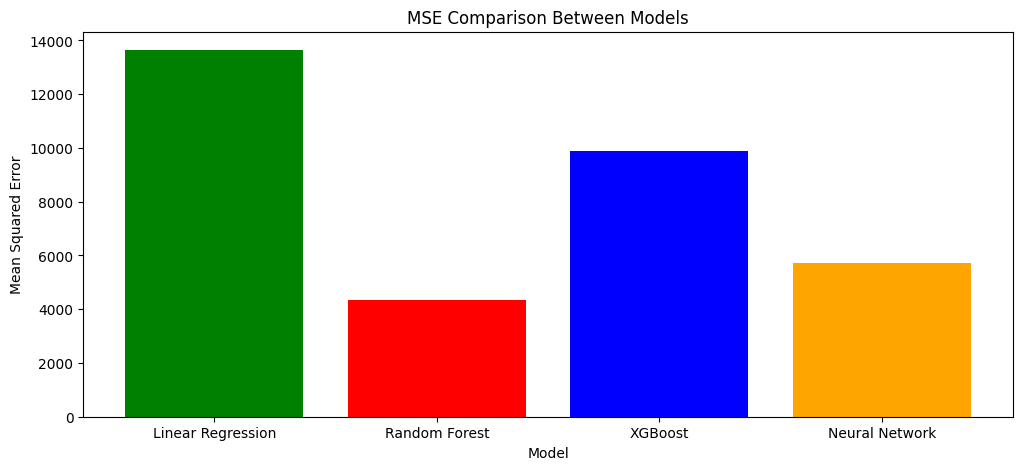

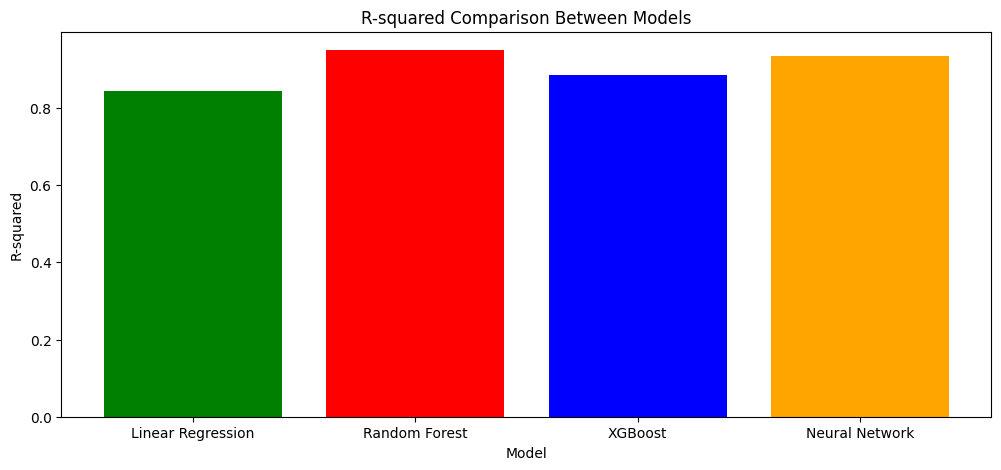

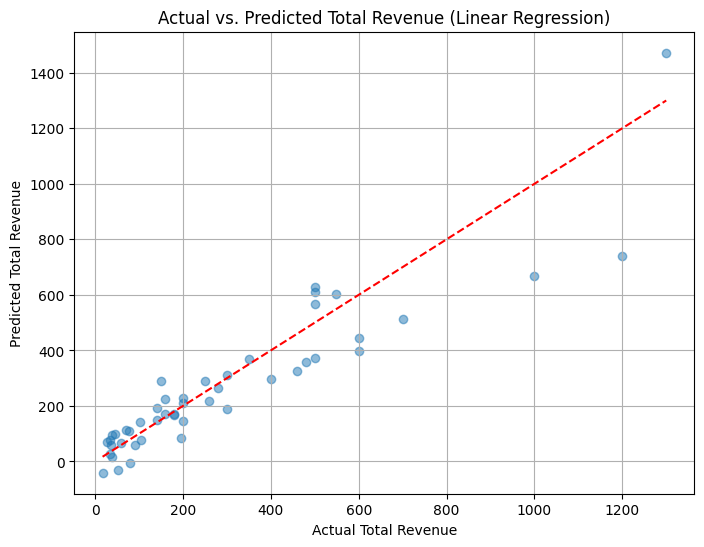

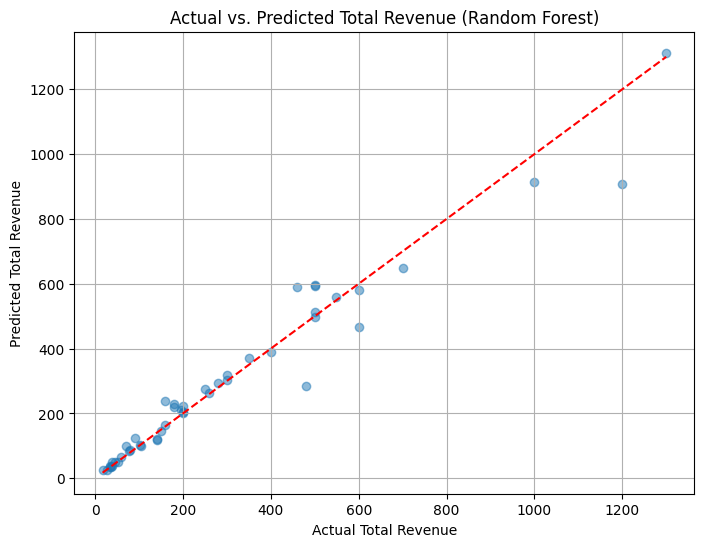

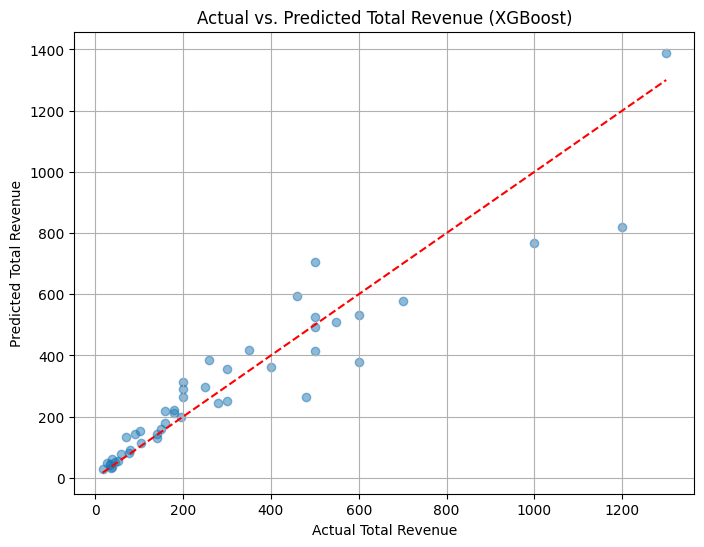

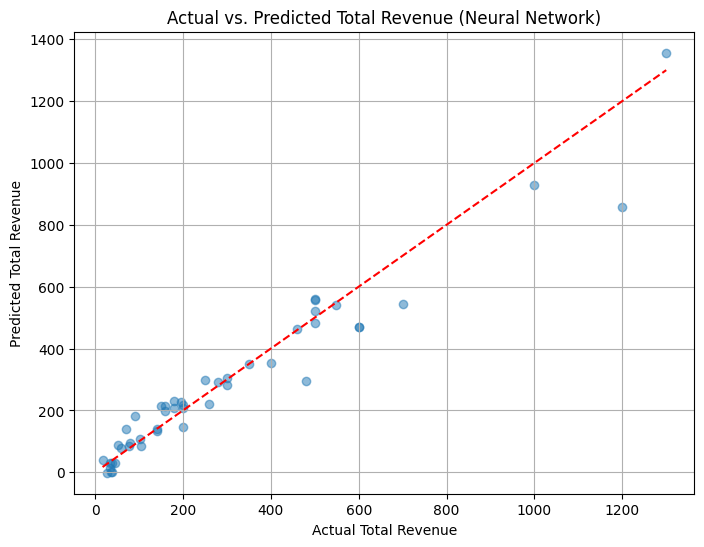

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Online Sales Data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shreyanshverma27/online-sales-dataset-popular-marketplace-data",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)
# Load dataset (assuming df is already loaded)
print("Shape of data before removing outliers:", df.shape)

# Identify and remove outliers using z-score method
z_scores = np.abs((df[['Units Sold', 'Unit Price', 'Total Revenue']] - df[['Units Sold', 'Unit Price', 'Total Revenue']].mean()) / df[['Units Sold', 'Unit Price', 'Total Revenue']].std())
df = df[(z_scores < 3).all(axis=1)]
print("Shape of data after removing outliers:", df.shape)

# Feature Engineering
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

encoder = LabelEncoder()
df['Region_Encoded'] = encoder.fit_transform(df['Region'])
df['Product Category_Encoded'] = encoder.fit_transform(df['Product Category'])
df['Payment Method_Encoded'] = encoder.fit_transform(df['Payment Method'])

X = df[['Units Sold', 'Unit Price', 'Month', 'Day', 'Weekday', 'Region_Encoded', 'Product Category_Encoded', 'Payment Method_Encoded']]
y = df['Total Revenue']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression - Mean Squared Error:", mse_lr)
print("Linear Regression - R-squared:", r2_lr)

# Random Forest Model with Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - Mean Squared Error:", mse_rf)
print("Random Forest - R-squared:", r2_rf)

# XGBoost Model with Hyperparameter Tuning
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, max_depth=8, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost - Mean Squared Error:", mse_xgb)
print("XGBoost - R-squared:", r2_xgb)

# Optimized Neural Network Model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train_scaled, y_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test_scaled, y_test))

y_pred_nn = nn_model.predict(X_test_scaled).flatten()

mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print("Neural Network - Mean Squared Error:", mse_nn)
print("Neural Network - R-squared:", r2_nn)

# Visualization
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network']
mse_values = [mse_lr, mse_rf, mse_xgb, mse_nn]
r2_values = [r2_lr, r2_rf, r2_xgb, r2_nn]

plt.figure(figsize=(12, 5))
plt.bar(models, mse_values, color=['green', 'red', 'blue', 'orange'])
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.title("MSE Comparison Between Models")
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(models, r2_values, color=['green', 'red', 'blue', 'orange'])
plt.xlabel("Model")
plt.ylabel("R-squared")
plt.title("R-squared Comparison Between Models")
plt.show()

# Predicted vs Actual Revenue Plots
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel('Actual Total Revenue')
    plt.ylabel('Predicted Total Revenue')
    plt.title(f'Actual vs. Predicted Total Revenue ({model_name})')
    plt.grid(True)
    plt.show()

for model_name, y_pred in zip(models, [y_pred_lr, y_pred_rf, y_pred_xgb, y_pred_nn]):
    plot_actual_vs_predicted(y_test, y_pred, model_name)


<ipython-input-7-dd8875659491>:22: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


Shape of data before removing outliers: (240, 9)
Shape of data after removing outliers: (232, 9)


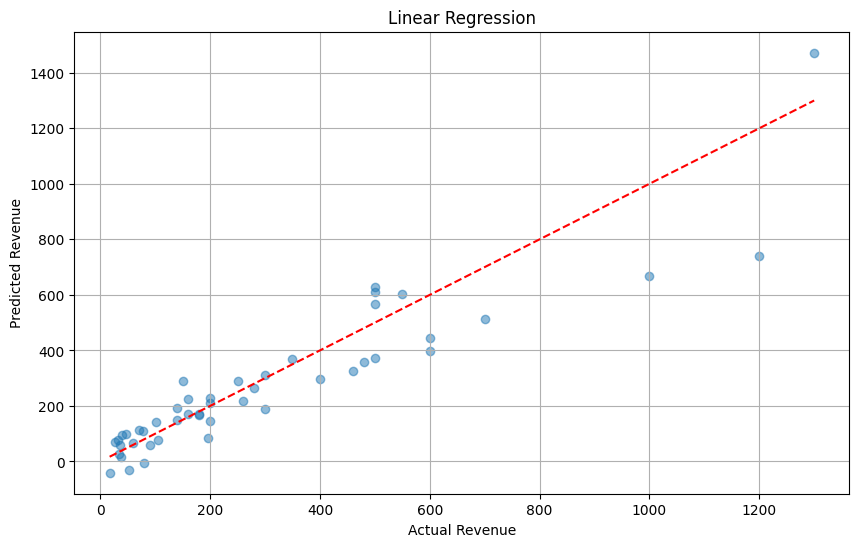

Linear Regression - Mean Squared Error: 13640.89623918579
Linear Regression - R-squared: 0.842789548976297


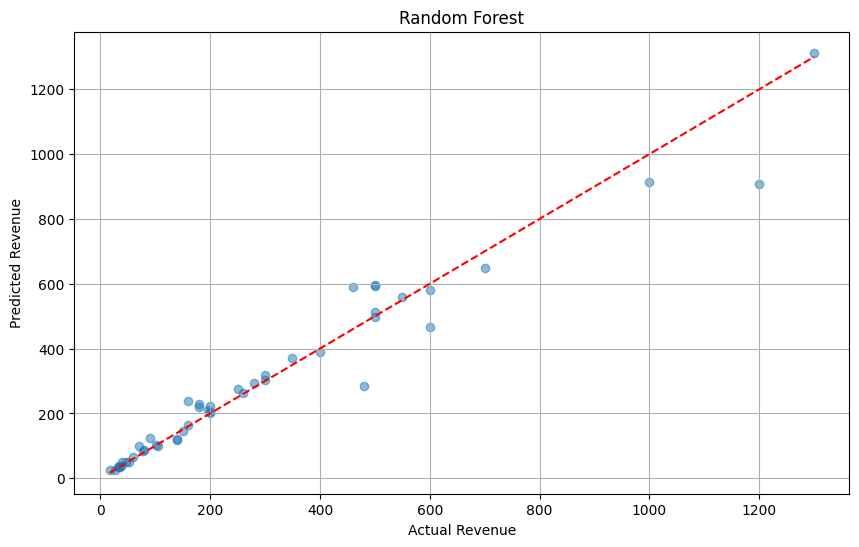

Random Forest - Mean Squared Error: 4329.049376411157
Random Forest - R-squared: 0.9501079846194842


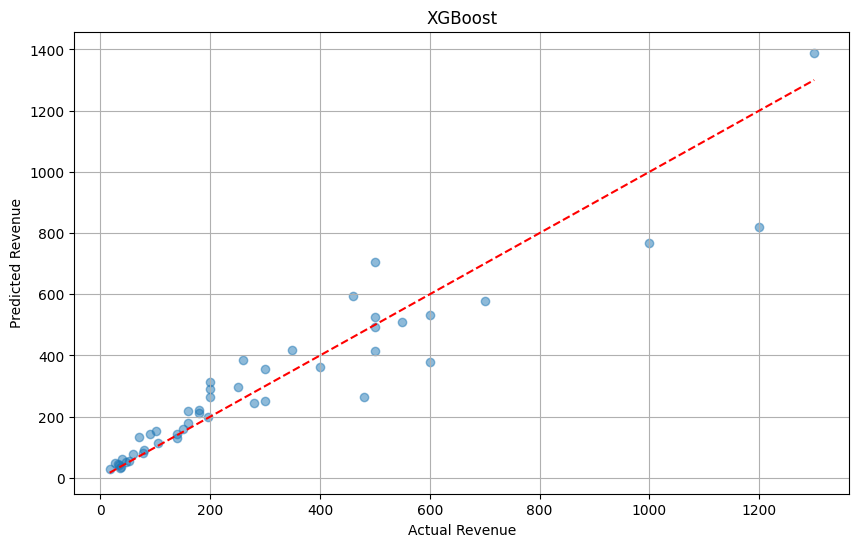

XGBoost - Mean Squared Error: 9899.454148992963
XGBoost - R-squared: 0.885909428210375


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


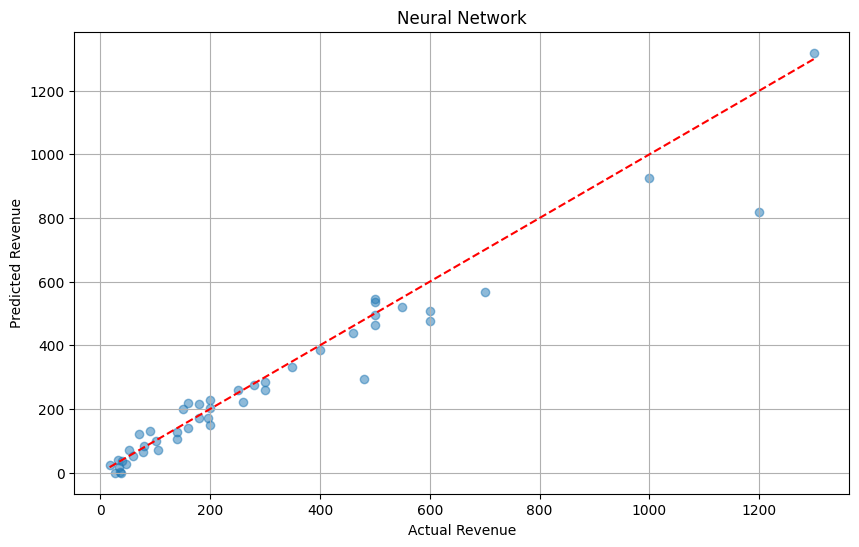

Neural Network - Mean Squared Error: 5547.125478441549
Neural Network - R-squared: 0.9360697359572524
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 164236.4062 - mae: 268.1479 - val_loss: 172879.0781 - val_mae: 293.5211
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 195110.5781 - mae: 278.8000 - val_loss: 171634.5000 - val_mae: 291.5668
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 147922.4219 - mae: 250.3420 - val_loss: 169107.5781 - val_mae: 287.5358
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 164771.9375 - mae: 266.0063 - val_loss: 164298.8438 - val_mae: 279.7142
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 160852.6250 - mae: 252.5288 - val_loss: 155709.9375 - val_mae: 265.7835
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 154266.8750 - mae: 253.5276 - val_loss: 141890.0781 - val_mae: 248.3015
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 138765.2656 - mae: 227.2257 - val_loss: 122805.7031 - val_mae: 226.5849
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 148200.2656 - mae: 217.7250 - val_loss: 10

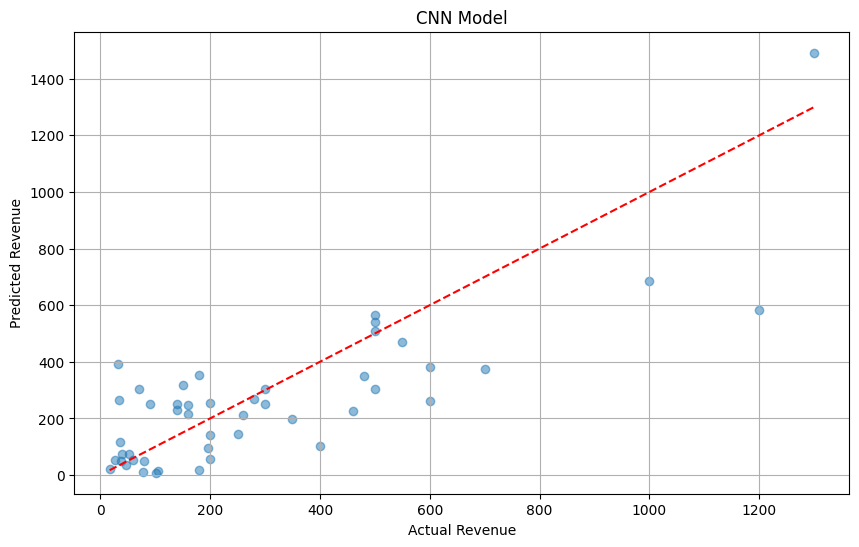

CNN Model - Mean Squared Error: 31467.819244711907
CNN Model - R-squared: 0.6373354089460617


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Reshape
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras
from tensorflow.keras import layers
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Online Sales Data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shreyanshverma27/online-sales-dataset-popular-marketplace-data",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)
# Load dataset (assuming df is already loaded)
print("Shape of data before removing outliers:", df.shape)

# Identify and remove outliers using z-score method
z_scores = np.abs((df[['Units Sold', 'Unit Price', 'Total Revenue']] - df[['Units Sold', 'Unit Price', 'Total Revenue']].mean()) / df[['Units Sold', 'Unit Price', 'Total Revenue']].std())
df = df[(z_scores < 3).all(axis=1)]
print("Shape of data after removing outliers:", df.shape)

# Feature Engineering
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

encoder = LabelEncoder()
df['Region_Encoded'] = encoder.fit_transform(df['Region'])
df['Product Category_Encoded'] = encoder.fit_transform(df['Product Category'])
df['Payment Method_Encoded'] = encoder.fit_transform(df['Payment Method'])

X = df[['Units Sold', 'Unit Price', 'Month', 'Day', 'Weekday', 'Region_Encoded', 'Product Category_Encoded', 'Payment Method_Encoded']]
y = df['Total Revenue']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to plot Actual vs Predicted
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
    plt.xlabel('Actual Revenue')
    plt.ylabel('Predicted Revenue')
    plt.title(title)
    plt.grid()
    plt.show()

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
plot_actual_vs_predicted(y_test, y_pred_lr, "Linear Regression")

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression - Mean Squared Error:", mse_lr)
print("Linear Regression - R-squared:", r2_lr)

# Random Forest Model with Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
plot_actual_vs_predicted(y_test, y_pred_rf, "Random Forest")

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - Mean Squared Error:", mse_rf)
print("Random Forest - R-squared:", r2_rf)

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, max_depth=8, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
plot_actual_vs_predicted(y_test, y_pred_xgb, "XGBoost")

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost - Mean Squared Error:", mse_xgb)
print("XGBoost - R-squared:", r2_xgb)

# Optimized Neural Network Model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train_scaled, y_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test_scaled, y_test))

y_pred_nn = nn_model.predict(X_test_scaled).flatten()
plot_actual_vs_predicted(y_test, y_pred_nn, "Neural Network")

mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print("Neural Network - Mean Squared Error:", mse_nn)
print("Neural Network - R-squared:", r2_nn)

# CNN Model
cnn_model = keras.Sequential([
    layers.Reshape((X_train_scaled.shape[1], 1), input_shape=(X_train_scaled.shape[1],)),  # Reshape input
    layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
cnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test_scaled, y_test))

y_pred_cnn = cnn_model.predict(X_test_scaled).flatten()
plot_actual_vs_predicted(y_test, y_pred_cnn, "CNN Model")

mse_cnn = mean_squared_error(y_test, y_pred_cnn)
r2_cnn = r2_score(y_test, y_pred_cnn)
print("CNN Model - Mean Squared Error:", mse_cnn)
print("CNN Model - R-squared:", r2_cnn)